# Escalado Predicciones

1. [Introducción](#introduccion)
<br></br>
2. [Carga del DataFrame](#carga-del-dataframe)
<br></br>
3. [Función que Extrae Datos por País y Producto](#funcion-que-extrae-datos-por-pais-y-producto)
<br></br>
4. [Generación de la Predicción](#generacion-de-la-prediccion)
<br></br>
5. [Evaluación de la Predicción](#evaluacion-de-la-prediccion)
<br></br>
6. [Conclusiones](#conclusiones)

In [1]:
%load_ext watermark
%watermark

2019-06-16T07:55:11+02:00

CPython 3.6.8
IPython 6.2.1

compiler   : GCC 7.3.0
system     : Linux
release    : 4.13.0-46-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit


## 1. <a id='introduccion'>Introducción</a>

Siguiendo con la filosofía de este proyecto de **crear predicciones en escala**, se crea este notebook con el que se pretende acelerar todo el proceso para conseguir la predicción.

El objetivo, por tanto, aquí es desarrollar un código que, a partir del DataFrame Base creado en el notebook "01.-Exploracion-de-los-Datos-y-Creacion-DataFrame-Base", se genere automáticamente una predicción con Prophet para un producto ('Product Code') y destino ('Destino').

## 2. <a id='carga-del-dataframe'>Carga del DataFrame</a>

In [2]:
import math
import numpy as np
import pandas as pd
from datetime import datetime,timedelta
import calendar
import matplotlib.pyplot as plt
from fbprophet import Prophet
import warnings

%matplotlib inline
plt.rcParams['figure.figsize'] = (18,10)
warnings.filterwarnings('ignore')

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [3]:
df = pd.read_pickle('../Data/01.-Exploracion-de-los-Datos-y-Creacion-DataFrame-Base.pkl')

df.head()

,Fecha_envio,Product_code,Origen,Destino,Peso,Volumen,Peso_final
0,2017-05-01,B,ES,NO,1.80,3.584,3.584
1,2017-05-01,B,ES,NO,0.90,2.242,2.242
2,2017-05-01,B,ES,NO,0.35,1.009,1.009
3,2017-05-01,B,ES,NO,1.15,2.130,2.130
4,2017-05-01,B,ES,NO,0.45,0.996,0.996


## 3. <a id='funcion-que-extrae-informacion-por-pais-y-producto'>Función que Extrae Datos por País y Producto</a>

In [4]:
def dataframe_creation(product,country):
    df_temp = df[(df['Product_code'] == product) & (df['Destino'] == country)]
    df_temp = df_temp.groupby(['Fecha_envio']).size().reset_index()
    return df_temp

In [5]:
df_N_ES = dataframe_creation('N','ES')

df_N_ES.head()

,Fecha_envio,0
0,2017-05-02,1993
1,2017-05-03,3193
2,2017-05-04,2759
3,2017-05-05,2503
4,2017-05-06,56


## 4. <a id='generacion-de-la-prediccion'>Generación de la Predicción</a>

Utilizamos la función creada en el Notebook "03a.-Implementacion-Prophet-a-df_U_FR.ipynb":

In [6]:
def new_y_for_date(date,df_temp):
    df_monthdays_for_date = df_temp.loc[(df_temp['ds'].dt.year == date.year) &
                                        (df_temp['ds'].dt.month == date.month) &
                                        (df_temp['ds'].dt.weekday == date.weekday())]
    new_y = df_monthdays_for_date['y'].mean()
    if math.isnan(new_y) == False:
        return np.int64(round(new_y))
    else:
        return np.int64(round(df_temp.loc[df_temp['ds'].dt.weekday == date.weekday()]['y'].mean()))

Generamos una función a partir de snippets de código del mismo Notebook, que nos genera un dataframe completo y preparado para ser procesado por Prophet:

In [7]:
def dataframe_creation(product,country):
    df_temp = df[(df['Product_code'] == product) & (df['Destino'] == country)]
    df_temp = df_temp.groupby(['Fecha_envio']).size().reset_index()
    df_temp.columns = ['ds','y']
    missing_dates = pd.date_range(start = '2017-05-01',end = '2019-04-01').difference(df_temp['ds'])
    df_missing_dates = pd.DataFrame()
    df_missing_dates['ds'] = missing_dates
    df_missing_dates['y'] = [new_y_for_date(date,df_temp) for date in df_missing_dates['ds']]
    df_temp = df_temp.append(df_missing_dates)
    df_temp['ds'] = pd.to_datetime(df_temp['ds'])
    df_temp = df_temp.sort_values(by = 'ds')
    df_temp = df_temp.reset_index(drop = True)
    return df_temp

Creamos una última función que genera la predicción a partir únicamente del 'Product_code', 'Destino' y el country_name_code, donde éste último ajusta a Prophet para que tenga en cuenta los días de vacaciones del país con el queramos trabajar:

In [8]:
def forecast(product,country,country_name_code):
    f = Prophet()
    f.add_country_holidays(country_name = country_name_code)
    f.fit(dataframe_creation(product,country))
    df_temp = f.make_future_dataframe(periods = 59)
    df_temp = f.predict(df_temp)
    return df_temp,f

Comprobamos que funciona correctamente. Utilizamos como ejemplo 'Product Code' N y 'Destino' España (ES):

In [9]:
df_N_ES,f = forecast('N','ES','FRA')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [10]:
df_N_ES.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Armistice 1918,Armistice 1918_lower,Armistice 1918_upper,Armistice 1945,...,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-05-01,1950.927279,947.699156,2337.728986,1950.927279,1950.927279,0.0,0.0,0.0,0.0,...,-1225.620865,-1225.620865,-1225.620865,877.949060,877.949060,877.949060,0.0,0.0,0.0,1603.255474
1,2017-05-02,1950.503967,1973.318099,3370.513097,1950.503967,1950.503967,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,731.654301,731.654301,731.654301,0.0,0.0,0.0,2682.158269
2,2017-05-03,1950.080656,1948.107511,3328.235548,1950.080656,1950.080656,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,712.444591,712.444591,712.444591,0.0,0.0,0.0,2662.525247
3,2017-05-04,1949.657344,1913.007575,3319.074948,1949.657344,1949.657344,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,664.932263,664.932263,664.932263,0.0,0.0,0.0,2614.589607
4,2017-05-05,1949.234033,1706.688911,3084.965605,1949.234033,1949.234033,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,450.226355,450.226355,450.226355,0.0,0.0,0.0,2399.460388


La función no sólo nos devuelve la predicción, sino también el modelo (f).

En este notebook estamos trabajando con todo el histórico de datos del que disponemos, no nos estamos reservando un porcentaje de los mismos para testear y generar métricas, en nuestro caso MAPE. Sin embargo, **Prophet dispone de herramientas de diagnóstico** que solucionan este problema. Y, para ello utilizaremos el modelo generado.

In [11]:
f

## 5. <a id='evaluacion-de-la-prediccion'>Evaluación de la Predicción</a>

Importamos las herramientas de diagnóstico de Prophet.

In [12]:
from fbprophet.diagnostics import cross_validation,performance_metrics
from fbprophet.plot import plot_cross_validation_metric

Configuramos cómo vamos a utilizar las herramientas de diagnóstico. En nuestro caso, al generar una predicción final de 2 meses (60 días), vamos a utilizar periodos de entrenamiento de 300 días (initial) y repetiremos el proceso en el histórico de datos cada 300 días (period). Así, mantendremos una proporción de 80% y 20% en cuanto a los datos con los que se realiza la predicción y cuál es longitud de la misma. 

In [13]:
initial = 5 * 60
initial = str(initial) + ' days'

period = 5 * 60
period = str(period) + ' days'

horizon = 60
horizon = str(horizon) + ' days'

In [14]:
df_N_ES_cv = cross_validation(f,initial = initial,period = period,horizon = horizon)

INFO:fbprophet:Making 2 forecasts with cutoffs between 2018-04-06 00:00:00 and 2019-01-31 00:00:00


In [15]:
df_N_ES_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-04-07,-112.453381,-766.830430,551.520347,65,2018-04-06
1,2018-04-08,-200.780683,-879.037085,456.204240,2,2018-04-06
2,2018-04-09,2757.237576,2165.056345,3418.472624,2408,2018-04-06
3,2018-04-10,2531.402139,1808.447797,3143.888414,2317,2018-04-06
4,2018-04-11,2461.050048,1789.915096,3098.531824,2230,2018-04-06


Y las métricas obtenidas para la predicción de 2 meses son:

In [16]:
performance_metrics(df_N_ES_cv)

,horizon,mse,rmse,mae,mape,coverage
0,6 days,1.053906e+06,1026.599148,503.052689,11.425493,0.916667
1,7 days,1.020429e+06,1010.162958,455.877445,11.174351,0.916667
2,8 days,1.026381e+06,1013.104569,468.598651,1.029693,0.916667
3,9 days,1.021738e+06,1010.810803,467.754910,12.847177,0.916667
4,10 days,1.015180e+06,1007.561506,447.719274,13.111181,0.916667
5,11 days,1.020372e+06,1010.134688,450.927228,13.112185,0.916667
6,12 days,4.841188e+04,220.026997,189.906218,13.072308,1.000000
7,13 days,5.850170e+04,241.871247,212.469131,13.079600,1.000000
8,14 days,5.080810e+04,225.406514,193.744662,12.331773,1.000000
9,15 days,4.778714e+04,218.602705,179.215868,1.192476,1.000000


Cómo se puede observar, se llega a tener en algunas fases un MAPE del 65%.

Gráficamente el comportamiento del MAPE a lo largo de los 2 meses es:

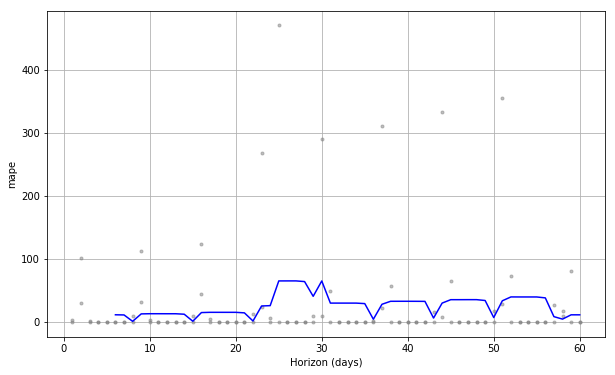

In [17]:
plot_cross_validation_metric(df_N_ES_cv,metric = 'mape');

In [18]:
print('El Error Porcentual Absoluto Medio (MAPE) de media en la predicción de 2 meses es: {}%'.format(
    round(performance_metrics(df_N_ES_cv)['mape'].mean())))

El Error Porcentual Absoluto Medio (MAPE) de media en la predicción de 2 meses es: 26%


## 6. <a id='conclusiones'>Conclusiones</a>

* **En este notebook, ya se ha conseguido escalar las predicciones** para nuestros datos, que era el objetivo inicial de este proyecto.
* Como ejemplo se ha utilizado 'Product Code' N y 'Destino' España, y se ha obtenido un MAPE del 26%. Éste es un excelente dato de partida pues no hemos aplicado las correcciones de eliminar los envíos negativos y no se han descartado los fines de semana, como se hizo en los notebooks *03a.-Implementacion-Prophet-a-df_U_FR* y 03b.-Implementacion-RNN-a-df_U_FR*.
* El MAPE de partida que se consigue para 'Product Code' U y 'Destino' FR, en los notebooks nombrados en el punto anterior, es del 1052.0%. Lo que confirma que sí es una excelente predicción la que genera el modelo creado en este notebook (MAPE = 26%)